In [3]:
import random
import time
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix

In [4]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [11]:
SAVED_MODEL_PATH = 'app/checkpoint/best_accuracy.pth'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [7]:
manual_seed = 1111
batch_size = 64
num_epoch = 30
valid_interval = 1
lr = 1e-4
use_gpu = True

In [8]:
random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manual_seed)

In [9]:
model = Model().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 314281803.67it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 102483666.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74213602.43it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23175825.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
best_eval_acc = 0
start = time.time()
for ep in range(num_epoch):
    avg_loss = 0
    model.train()
    print(f"{ep + 1}/{num_epoch} epoch start")

    for i, (imgs, labels) in enumerate(trainloader):
        imgs, labels = imgs.to(device), labels.to(device)

        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

        if i > 0 and i % 100 == 0:
            print(f"loss:{avg_loss / 100:.4f}")
            avg_loss = 0

    if ep % valid_interval == 0:
        tp, cnt = 0, 0
        model.eval()
        for i, (imgs, labels) in enumerate(valloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                preds = model(imgs)
            preds = torch.argmax(preds, dim=1)
            tp += (preds == labels).sum().item()
            cnt += labels.shape[0]
        acc = tp / cnt
        print(f"eval acc:{acc:.4f}")

    if acc > best_eval_acc:
        best_eval_acc = acc

        if not os.path.exists(os.path.dirname(SAVED_MODEL_PATH)):
            os.makedirs(os.path.dirname(SAVED_MODEL_PATH))

        torch.save(model.state_dict(), SAVED_MODEL_PATH)

    print(f"{ep + 1}/{num_epoch} epoch finished. elapsed time:{time.time() - start:.1f} sec")

print(f"training finished. best eval acc:{best_eval_acc:.4f}")

1/30 epoch start
loss:1.7678
loss:1.5455
loss:1.5197
loss:1.5021
loss:1.5000
loss:1.4995
loss:1.4972
loss:1.4984
loss:1.4884
eval acc:0.9745
1/30 epoch finished. elapsed time:23.8 sec
2/30 epoch start
loss:1.5017
loss:1.4877
loss:1.4844
loss:1.4795
loss:1.4839
loss:1.4835
loss:1.4810
loss:1.4862
loss:1.4791
eval acc:0.9861
2/30 epoch finished. elapsed time:48.0 sec
3/30 epoch start
loss:1.4942
loss:1.4803
loss:1.4775
loss:1.4746
loss:1.4796
loss:1.4781
loss:1.4791
loss:1.4808
loss:1.4755
eval acc:0.9843
3/30 epoch finished. elapsed time:67.9 sec
4/30 epoch start
loss:1.4900
loss:1.4764
loss:1.4748
loss:1.4718
loss:1.4757
loss:1.4762
loss:1.4756
loss:1.4763
loss:1.4745
eval acc:0.9847
4/30 epoch finished. elapsed time:90.7 sec
5/30 epoch start
loss:1.4885
loss:1.4725
loss:1.4711
loss:1.4706
loss:1.4746
loss:1.4741
loss:1.4739
loss:1.4760
loss:1.4739
eval acc:0.9872
5/30 epoch finished. elapsed time:114.3 sec
6/30 epoch start
loss:1.4863
loss:1.4718
loss:1.4724
loss:1.4687
loss:1.4746
lo

## Učitavanje i evaluacija modela

In [13]:
model = Model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [14]:
if os.path.exists(SAVED_MODEL_PATH):
    model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    print("Model weights loaded successfully.")
else:
    print("Model weights file not found. Please check the path.")

Model weights loaded successfully.


In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
valloader = DataLoader(valset, batch_size=5, shuffle=True)

In [16]:
def evaluate_model(model, loader, device):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

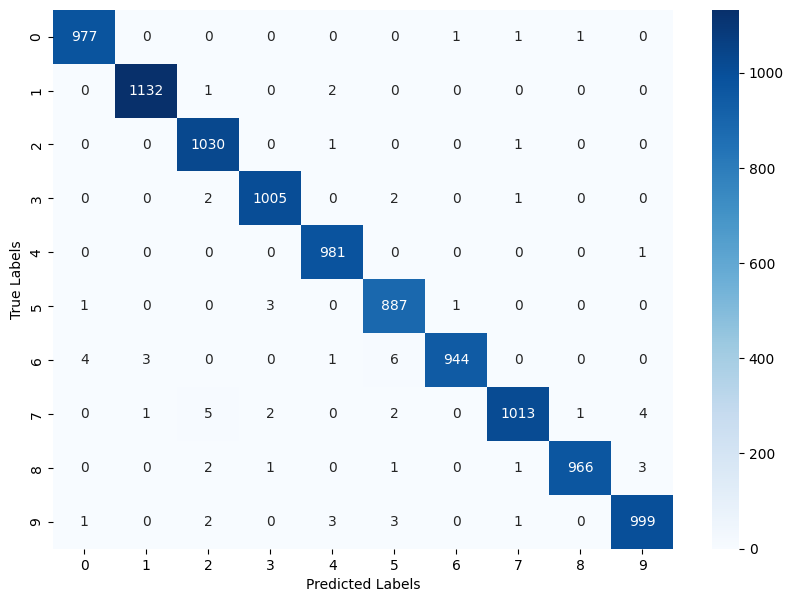

In [17]:
all_preds, all_labels = evaluate_model(model, valloader, device)

pred_labels = all_preds.argmax(dim=1)
cm = confusion_matrix(all_labels.numpy(), pred_labels.numpy())

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
def visualize_images(images, true_labels, predicted_labels, figsize=(15, 3)):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        axs[i].imshow(images[i].squeeze(), cmap='gray')
        title = f'Label: {true_labels[i]}\nPrediction: {predicted_labels[i]}'
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

In [19]:
def visualize_predictions(model, data_loader, device, num_images=5):
    images, labels = next(iter(data_loader))
    images, labels = images.to(device)[:num_images], labels.to(device)[:num_images]
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    visualize_images(images.cpu().numpy(), labels.cpu().numpy(), predicted.cpu().numpy())

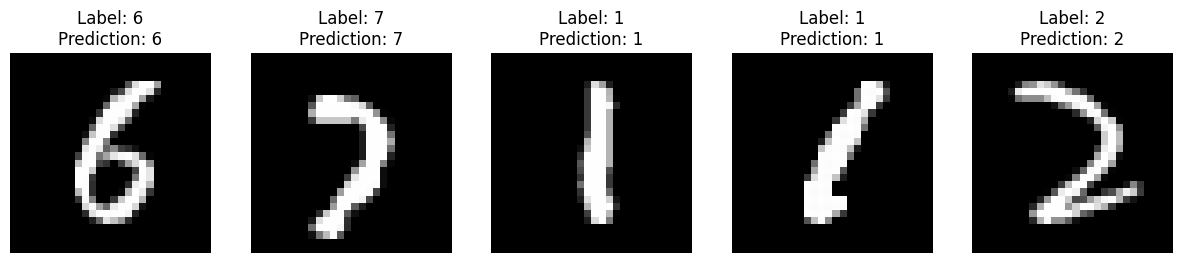

In [20]:
visualize_predictions(model, valloader, device, num_images=5)

In [21]:
def visualize_incorrect_predictions(model, data_loader, device, num_images=5):
    model.eval()
    incorrect_images, incorrect_labels, incorrect_preds = [], [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            mismatches = preds != labels
            for i, mismatch in enumerate(mismatches):
                if mismatch and len(incorrect_images) < num_images:
                    incorrect_images.append(images[i].cpu().numpy())
                    incorrect_labels.append(labels[i].item())
                    incorrect_preds.append(preds[i].item())
                if len(incorrect_images) == num_images:
                    break
            if len(incorrect_images) == num_images:
                break
    if len(incorrect_images) > 0:
        visualize_images(np.array(incorrect_images), incorrect_labels, incorrect_preds)
    else:
        print("No incorrect predictions found or not enough samples to display.")

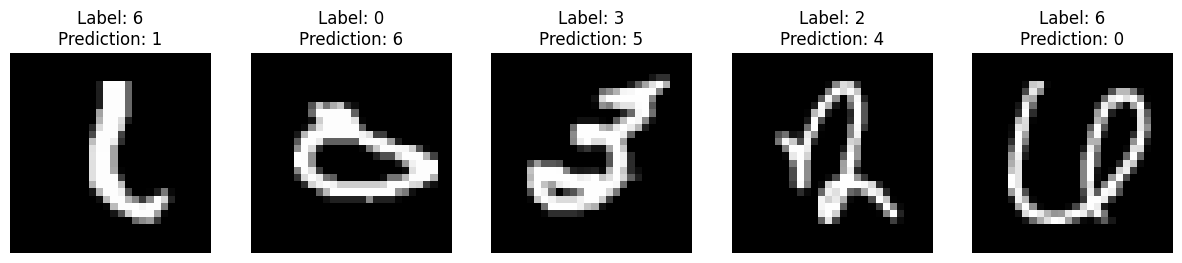

In [23]:
visualize_incorrect_predictions(model, valloader, device, num_images=5)